In [1]:
# libraries used
import numpy as np
import pandas as pd
import time

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn import linear_model
from matplotlib import pyplot
from sklearn.feature_selection import SelectFromModel

In [2]:
# importing the merged dataset
data = pd.read_csv('ensembleMean_Spain.csv')

First of all, we split the data set into training and testing in order to get a higher precision of metrics. 

The training part includes the electricity data before year 2018 while the testing set includes the electricity data after 2018. 

In [3]:
# splitting data set into training set and testing set (OUTER)

train = data[data['time']<'2018-01-01 00:00:00'] # trainig set are data from dates before 2018
test = data[data['time']>='2018-01-01 00:00:00'] # testing set are data from dates after 2018

In [4]:
# splitting the sets into variables and response
y_train = train['response'].values
x_train = train[[x for x in train.columns if (x != 'response') & (x != 'time')]].values

y_test = test['response'].values
x_test = test[[x for x in test.columns if (x != 'response') & (x != 'time')]].values

In [5]:
x_test.shape

(2920, 3536)

Then we split the training part into training set and validation set in order to set a custom cross validation method. 

The reason to do so is, it is only possible to use the previous data to predict the future, therefore, we split the data into 3 different times to train the different models. 
- dates before 2017 as the training set;
- dates from 2017-2018 as the validation set (in order to tune the hyperparameters of each single model that we will be using in the project); 
- and the dates after 2018 as the testing set (in order to compare the different metrics for each model that we have trained) 

In [6]:
train[train['time']=='2017-01-01 00:00:00'] # checking the first day of 2017 in order to split training from validation(INNER)

,time,norma_10_36.0_-0.5,norma_10_36.0_-1.0,norma_10_36.0_-1.5,norma_10_36.0_-2.0,norma_10_36.0_-2.5,norma_10_36.0_-3.0,norma_10_36.0_-3.5,norma_10_36.0_-4.0,norma_10_36.0_-4.5,...,v100_44.0_-9.0,v100_44.0_-9.5,v100_44.0_0.0,v100_44.0_0.5,v100_44.0_1.0,v100_44.0_1.5,v100_44.0_2.0,v100_44.0_2.5,v100_44.0_3.0,response
5848,2017-01-01 00:00:00,1.906174,2.611856,3.791657,4.621365,5.310724,6.139571,7.04824,7.666611,7.167265,...,-0.622075,-0.645622,0.578852,0.635822,0.834078,1.299713,1.548102,1.428845,0.800656,111150.249


In [7]:
train.iloc[5848]

time                  2017-01-01 00:00:00
norma_10_36.0_-0.5                1.90617
norma_10_36.0_-1.0                2.61186
norma_10_36.0_-1.5                3.79166
norma_10_36.0_-2.0                4.62137
                             ...         
v100_44.0_1.5                     1.29971
v100_44.0_2.0                      1.5481
v100_44.0_2.5                     1.42884
v100_44.0_3.0                    0.800656
response                           111150
Name: 5848, Length: 3538, dtype: object

In [8]:
# Splitting indeces to create a custom cv 

train_indices = list(range(0,5848))                  # dates before 2017 to train
test_indices = list(range(5848, len(train)))         # dates from 2017 to 2018 to validate (INNER)
custom_cv = [(train_indices, test_indices)]

In [9]:
# creating a metrics matrix in order to visualize the different results
df_metricas=pd.DataFrame(columns=['train_R2', 'test_R2', 'train_MAXerror', 'test_MAXerror',
                                 'train_mae', 'test_mae', 'train_mse', 'test_mse', 
                                  'train_rmse', 'test_rmse'], 
                         index=['RF','GB','SVM','lm','lm_all_vars'])

In [10]:
# Metrics for evaluating
def metrics(y_train, pred_train, y_test, pred_test, model):
    # Varianza explicada
    ve_train = explained_variance_score(y_train, pred_train)
    ve_test = explained_variance_score(y_test, pred_test)
    print('explained variance of training set:',(ve_train))
    print('explained variance of testing set:',(ve_test))
    df_metricas.loc[model, 'train_R2']=ve_train
    df_metricas.loc[model, 'test_R2']=ve_test
    # Maximum error
    me_train = max_error(pred_train, y_train)
    me_test = max_error(pred_test, y_test)
    print('maximum error of training set:',(me_train))
    print('maximum error of testing set:',(me_test))
    df_metricas.loc[model, 'train_MAXerror']=me_train
    df_metricas.loc[model, 'test_MAXerror']=me_test
    # mean absolute error: datos mal predichos, no al cuadrado, menor peso
    mae_train = mean_absolute_error(pred_train, y_train)
    mae_test = mean_absolute_error(pred_test, y_test)
    print('mae of training set:',(mae_train))
    print('mae of testing set:',(mae_test))
    df_metricas.loc[model, 'train_mae']=mae_train
    df_metricas.loc[model, 'test_mae']=mae_test
    # mean squared error: al cuadrado 
    # raiz de mse
    mse_train = mean_squared_error(pred_train, y_train)
    mse_test = mean_squared_error(pred_test, y_test)
    print('mse of training set:',(mse_train))
    print('mse of testing set:',(mse_test))
    df_metricas.loc[model, 'train_mse']=mse_train
    df_metricas.loc[model, 'test_mse']=mse_test
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    print('rmse of training set:',(rmse_train))
    print('rmse of testing set:',(rmse_test))
    df_metricas.loc[model, 'train_rmse']=rmse_train
    df_metricas.loc[model, 'test_rmse']=rmse_test

### Linear Model in order to find the best predictors 

In [11]:
from sklearn import linear_model

lm = linear_model.LinearRegression()
lm.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [12]:
lm_pred_train = lm.predict(x_train)
lm_pred_test = lm.predict(x_test)

In [13]:
metrics(y_train, lm_pred_train, y_test, lm_pred_test, 'lm_all_vars')

explained variance of training set: 0.9803943000970675
explained variance of testing set: 0.9250961994990482
maximum error of training set: 184837.2621007465
maximum error of testing set: 396570.13765289314
mae of training set: 21766.850759637444
mae of testing set: 44624.01357955864
mse of training set: 789469611.1508766
mse of testing set: 3325849568.3987036
rmse of training set: 28097.501866729657
rmse of testing set: 57670.17919513259


Feature: 0, Score: 2393.47381
Feature: 1, Score: 3695.45961
Feature: 2, Score: 1344.78841
Feature: 3, Score: -146.56939
Feature: 4, Score: 5196.64684
Feature: 5, Score: -2080.70104
Feature: 6, Score: -646.70533
Feature: 7, Score: 4209.66384
Feature: 8, Score: -5857.91191
Feature: 9, Score: -3436.92834
Feature: 10, Score: 2213.53159
Feature: 11, Score: 4565.86703
Feature: 12, Score: -1508.10446
Feature: 13, Score: 20088.26861
Feature: 14, Score: -22670.23270
Feature: 15, Score: 8522.50619
Feature: 16, Score: -4579.13351
Feature: 17, Score: -22715.37662
Feature: 18, Score: 6359.25617
Feature: 19, Score: 4312.97294
Feature: 20, Score: -5838.11654
Feature: 21, Score: 6782.20047
Feature: 22, Score: 2515.41193
Feature: 23, Score: -5594.74932
Feature: 24, Score: 14108.68026
Feature: 25, Score: -2286.25786
Feature: 26, Score: 6247.58628
Feature: 27, Score: -1099.89536
Feature: 28, Score: -12954.62151
Feature: 29, Score: 11716.55547
Feature: 30, Score: -16044.61417
Feature: 31, Score: 4705.3747

Feature: 1386, Score: -89062.68673
Feature: 1387, Score: 636028.89825
Feature: 1388, Score: -565808.13667
Feature: 1389, Score: 45626.34868
Feature: 1390, Score: 407193.80413
Feature: 1391, Score: -392531.37757
Feature: 1392, Score: -75333.91851
Feature: 1393, Score: 30131.09458
Feature: 1394, Score: -61069.62959
Feature: 1395, Score: 663987.55191
Feature: 1396, Score: -584281.32916
Feature: 1397, Score: 32384.57699
Feature: 1398, Score: 28373.09635
Feature: 1399, Score: 465773.86020
Feature: 1400, Score: -490081.64277
Feature: 1401, Score: -23849.77840
Feature: 1402, Score: -84597.51577
Feature: 1403, Score: 86319.56664
Feature: 1404, Score: 300114.69991
Feature: 1405, Score: -645843.19442
Feature: 1406, Score: 461871.57916
Feature: 1407, Score: -60996.79918
Feature: 1408, Score: 576691.06495
Feature: 1409, Score: -1226953.35255
Feature: 1410, Score: 757558.17226
Feature: 1411, Score: -104628.57180
Feature: 1412, Score: 253884.82846
Feature: 1413, Score: -475348.82122
Feature: 1414, S

Feature: 3046, Score: -462575.82985
Feature: 3047, Score: 188767.28441
Feature: 3048, Score: 826411.70622
Feature: 3049, Score: -1321156.22624
Feature: 3050, Score: 809263.66671
Feature: 3051, Score: 17179.37751
Feature: 3052, Score: -598017.03901
Feature: 3053, Score: 563688.87602
Feature: 3054, Score: -478681.01686
Feature: 3055, Score: 305907.75016
Feature: 3056, Score: 42099.50734
Feature: 3057, Score: -152173.77196
Feature: 3058, Score: -81219.73995
Feature: 3059, Score: 282262.81315
Feature: 3060, Score: -130213.25798
Feature: 3061, Score: -6795.20327
Feature: 3062, Score: -356993.37919
Feature: 3063, Score: 802187.94620
Feature: 3064, Score: -807417.53634
Feature: 3065, Score: 935298.87380
Feature: 3066, Score: -571618.07502
Feature: 3067, Score: 43199.93721
Feature: 3068, Score: -393238.95246
Feature: 3069, Score: 309698.25384
Feature: 3070, Score: -286999.13651
Feature: 3071, Score: 575982.15396
Feature: 3072, Score: -476945.73034
Feature: 3073, Score: 305859.71644
Feature: 30

Feature: 3385, Score: 615216.11595
Feature: 3386, Score: -1523848.74332
Feature: 3387, Score: -891174.52775
Feature: 3388, Score: -1089905.17933
Feature: 3389, Score: 412097.73362
Feature: 3390, Score: -67044.33294
Feature: 3391, Score: 154276.99633
Feature: 3392, Score: -295725.23777
Feature: 3393, Score: 1114918.45864
Feature: 3394, Score: -664397.03287
Feature: 3395, Score: -97945.15575
Feature: 3396, Score: 597438.34046
Feature: 3397, Score: -1337745.29859
Feature: 3398, Score: -398859.81829
Feature: 3399, Score: -6684.25343
Feature: 3400, Score: -128789.16823
Feature: 3401, Score: -1468387.75685
Feature: 3402, Score: 324216.12282
Feature: 3403, Score: -243497.22902
Feature: 3404, Score: -215000.76408
Feature: 3405, Score: -28785.46646
Feature: 3406, Score: 571803.52347
Feature: 3407, Score: -9491.32255
Feature: 3408, Score: -782971.59511
Feature: 3409, Score: 702883.43238
Feature: 3410, Score: -1156647.79746
Feature: 3411, Score: 457248.72243
Feature: 3412, Score: 968961.43354
Fea

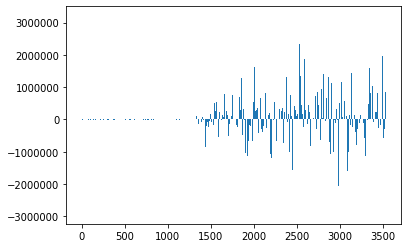

In [14]:
importance = lm.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [15]:
selector = SelectFromModel(estimator=linear_model.LinearRegression(),max_features = 150).fit(x_train, y_train)
selector.estimator_.coef_

array([ 2.39347381e+03,  3.69545961e+03,  1.34478841e+03, ...,
       -1.45976784e+06,  1.18080530e+06, -2.75373684e+05])

In [16]:
selector.threshold_

322177.18925551174

In [17]:
x_train = selector.transform(x_train)
x_test = selector.transform(x_test)

### Defining different functions to ease the process

During the project, we will be using three most popular methods which are the as the followings: 
1. Random Forest
2. Gradient Boosting
3. Support Vector Machines

We define different functions in order to facilitate the process of training part, by using these functions, it is only necessary to give three arguments: 
1. Training set
2. Testing set 
3. The different values that we want to tune for the hyperparameters

In [18]:
# 1. Random forest
def optimize_rf(x_train, y_train, params_rf):
    rf=RandomForestRegressor(random_state = 10)
    rf_search = RandomizedSearchCV(rf, params_rf, cv=custom_cv, n_iter = 30)
    rf_search.fit(x_train, y_train)
    return rf_search.best_estimator_

In [19]:
# 2. Gradient boosting
def optimize_gb(x_train, y_train, params_gb):
    gb=GradientBoostingRegressor(random_state = 10)
    gb_search = RandomizedSearchCV(gb, params_gb, cv=custom_cv, n_iter = 30)
    gb_search.fit(x_train, y_train)
    return gb_search.best_estimator_

In [20]:
# 3. SVM
def optimize_svm(x_train, y_train, params_svm):   
    svm = SVR()
    svm_search = RandomizedSearchCV(svm, params_svm, cv=custom_cv, n_iter = 30)
    svm_search.fit(x_train, y_train)
    return svm_search.best_estimator_

With the intention of visualization of the different results of metrics per model, we create a matrix that displays all the results of each model per each data set that we modify. 


Also, it is necessary to create a function that automatically does the imputation in the matrix for us. 

The function made requires 5 arguments: the true reponse (y element) for training set and testing set; the prediction of the response that the different models have made and the name of the model. 

#### 1.1 Random Forest

For random forest, we tune 4 different hyperparameters: 
- max_depth which is the maximum number of levels in each decision tree, we tune it randomly in range $[4, 7)$;
- min_samples_leaf which is the minimum number of instances allowed in a leaf node, we tune it randomly in range $[4, 12)$;
- n_estimators which is the number of trees in the forest, we tune it randomly in range $[130, 280)$;
- and max_features which is the maximum number of features considered for splitting a node, we tune it randomly in range $[25, 38)$

In [21]:
start_rf = time.time()

params_rf = {'max_depth': sp_randint(3, 6), 'min_samples_leaf': sp_randint(15, 30),
             'n_estimators': sp_randint(400, 500), 'max_features': sp_randint(40, 60)}
rf1 = optimize_rf(x_train, y_train, params_rf)

end_rf = time.time()
time_rf = end_rf - start_rf

In [22]:
time_rf

1307.8664436340332

The best hyperparameters for the random forest model are as follows:


In [23]:
rf1

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features=44, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=26,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=480, n_jobs=None, oob_score=False,
                      random_state=10, verbose=0, warm_start=False)

In [24]:
rf1_pred_train = rf1.predict(x_train)
rf1_pred_test = rf1.predict(x_test)

In [25]:
metrics(y_train, rf1_pred_train, y_test, rf1_pred_test, 'RF')

explained variance of training set: 0.8218455665929868
explained variance of testing set: 0.7809516254673583
maximum error of training set: 361368.9850140825
maximum error of testing set: 350799.5832479057
mae of training set: 68541.85522723563
mae of testing set: 79182.18121944279
mse of training set: 7173877787.973399
mse of testing set: 9511024119.841818
rmse of training set: 84698.74726330608
rmse of testing set: 97524.47959277619


#### 1.2 Gradient Boosting

For gradient boosting, we tune 4 different hyperparameters: 

- learning_rate determines the weight of each tree added to the global model, we tune it randomly in range $(0.0001, 0.6)$;
- n_estimators which is the number of trees in the forest, we tune it randomly in range $[180, 300)$;
- max_depth which is the maximum number of levels in each decision tree, we tune it randomly in range $[4, 8)$;
- min_samples_leaf which is the minimum number of instances allowed in a leaf node, we tune it randomly in range $[4, 10)$;

In [26]:
start_gb = time.time()

params_gb = {'learning_rate': loguniform(0.0001, 0.3), 'n_estimators':sp_randint(600, 800),
             'max_depth':sp_randint(3, 5), 'min_samples_leaf':sp_randint(35, 50)}
gb1 = optimize_gb(x_train, y_train, params_gb)

end_gb = time.time()
time_gb = end_gb - start_gb

In [27]:
time_gb

44255.77482199669

In [28]:
gb1

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.12131210944748512,
                          loss='ls', max_depth=4, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=44,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=756, n_iter_no_change=None,
                          presort='deprecated', random_state=10, subsample=1.0,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)

In [29]:
gb1_pred_train = gb1.predict(x_train)
gb1_pred_test = gb1.predict(x_test)

In [30]:
metrics(y_train, gb1_pred_train, y_test, gb1_pred_test, 'GB')

explained variance of training set: 0.9935666722365176
explained variance of testing set: 0.9322541417305491
maximum error of training set: 116070.3807766973
maximum error of testing set: 379103.78758897417
mae of training set: 12462.384193391774
mae of testing set: 40782.627894121724
mse of training set: 259053070.9430531
mse of testing set: 2940990175.060068
rmse of training set: 16095.125688948598
rmse of testing set: 54230.896867561285


#### 1.3 Support Vector Machine

For support vector machine method, we tune 3 different hyperparameters: 

- kernel, it is a function used so that the data points become linearly separable, it is set to be rbf.
- C, C parameter adds a penalty for each misclassified data point.
- gamma, gamma parameter of RBF controls the distance of influence of a single training point

In [31]:
start_svm = time.time()

params_svm = {'C': loguniform(10e-5, 10e+5),
              'gamma': loguniform(10e-5, 10e+1),
              'kernel': ['rbf']}
svm1 = optimize_svm(x_train, y_train, params_svm)

end_svm = time.time()
time_svm = end_svm - start_svm

In [32]:
time_svm

381.58087706565857

The best hyperparameters for SVM model are as follows:

In [33]:
svm1

SVR(C=32391.722753598082, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma=0.0015654150474176103, kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [34]:
svm1_pred_train = svm1.predict(x_train)
svm1_pred_test = svm1.predict(x_test)

In [35]:
metrics(y_train, svm1_pred_train, y_test, svm1_pred_test, 'SVM')

explained variance of training set: 0.9612780429265885
explained variance of testing set: 0.9078922503331597
maximum error of training set: 304398.2105747758
maximum error of testing set: 426696.60409075685
mae of training set: 24585.700062038508
mae of testing set: 45787.97209751796
mse of training set: 1570362013.84969
mse of testing set: 4002794532.247803
rmse of training set: 39627.79345168855
rmse of testing set: 63267.64206328384


#### 1.4 LM

In [36]:
lm = linear_model.LinearRegression()
lm.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [37]:
lm_pred_train = lm.predict(x_train)
lm_pred_test = lm.predict(x_test)

In [38]:
metrics(y_train, lm_pred_train, y_test, lm_pred_test, 'lm')

explained variance of training set: 0.6826391530699898
explained variance of testing set: 0.6502245505354899
maximum error of training set: 599535.8251958597
maximum error of testing set: 526391.65000228
mae of training set: 87894.6320250225
mae of testing set: 98468.16306598914
mse of training set: 12779280804.092766
mse of testing set: 15397458791.537457
rmse of training set: 113045.48113079429
rmse of testing set: 124086.49721681024


Training by support vector machine using all the variables, we can find out that it did not work pretty well due to the fact that it needs more computer cost in order to get more precission. Due to the condition that we have, we will just leave it like that. 

In [39]:
df_metricas

,train_R2,test_R2,train_MAXerror,test_MAXerror,train_mae,test_mae,train_mse,test_mse,train_rmse,test_rmse
RF,0.821846,0.780952,361369,350800,68541.9,79182.2,7.17388e+09,9.51102e+09,84698.7,97524.5
GB,0.993567,0.932254,116070,379104,12462.4,40782.6,2.59053e+08,2.94099e+09,16095.1,54230.9
SVM,0.961278,0.907892,304398,426697,24585.7,45788,1.57036e+09,4.00279e+09,39627.8,63267.6
lm,0.682639,0.650225,599536,526392,87894.6,98468.2,1.27793e+10,1.53975e+10,113045,124086
lm_all_vars,0.980394,0.925096,184837,396570,21766.9,44624,7.8947e+08,3.32585e+09,28097.5,57670.2


In [40]:
time_running = pd.DataFrame(columns=['time_to_run'], 
                         index=['RF_all','GB_all','SVM_all'])

In [41]:
time_running.loc['RF_all','time_to_run']=time_rf
time_running.loc['GB_all','time_to_run']=time_gb
time_running.loc['SVM_all','time_to_run']=time_svm

Observing this table which contains the time spent runing using all the variables, we can see that gradient boosting method has taken the longest time to finish runing, but also it worked the best.

In [42]:
time_running

,time_to_run
RF_all,1307.87
GB_all,44255.8
SVM_all,381.581
